In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# load dataset
df = pd.read_csv("project/resources/Hotels_data_Changed.csv")
# validates that there are no null values in the dataset
df.isnull().values.any()

False

In [4]:
num_hotels = 151

# מצא את 150 בתי המלון המכילים הכי הרבה רשומות בקובץ המקורי. ניקח רק נתונים של מלונות אלה
print("Number of rows before formatting the data:", len(df))
idx = df.groupby("Hotel Name", sort=False)["Hotel Name"].count().nlargest(num_hotels)

hotel_names = list(idx.keys())
df = df[df["Hotel Name"].isin(hotel_names)]
print("Number of rows after GroupBy the data to take maximum discount price:", len(df))


Number of rows before formatting the data: 187848
Number of rows after GroupBy the data to take maximum discount price: 169515


In [5]:
num_dates = 40

# מצא את 40 תאריכי ה Checkin המכילים הכי הרבה רשומות. ניקח רק את הנתונים של תאריכים אלה.

print("Number of rows before formatting the data:", len(df))
idx = df.groupby("Checkin Date", sort=False)["Checkin Date"].count().nlargest(num_dates)
most_dates = list(idx.keys())
df = df[df["Checkin Date"].isin(most_dates)]
print("Number of rows after GroupBy the data to take maximum discount price:", len(df))


Number of rows before formatting the data: 169515
Number of rows after GroupBy the data to take maximum discount price: 60455


In [6]:
df1 = df[['Hotel Name', 'Checkin Date', 'Discount Code', 'Discount Price']]


In [7]:
# עבור כל תאריך Checkin, ניקח את 4 המחירים עבור 4 קודי ההנחות.
# סה"כ נקבל לכל בית מלון 160 מספרים (40 תאריכים * 4 מחירים).
# שימו לב שייתכן כי בתאריכים מסוימים לא יימצאו נתונים עבור בית המלון הספציפי – במקרה זה נסמן מחיר של -1.
# שימו לב כי כל לתאריך Checkin יש יותר מ snapshot אחד,

# עבור כל תאריך Checkin לבית מלון מסוים ניקח את זה בעל המחיר (לאחר הנחה) המינימאלי
# מבין כל ה snapshot-ים של מלון זה לאותו תאריך Checkin

df_min_price = df1.loc[df1.groupby(['Hotel Name', 'Checkin Date', 'Discount Code'])['Discount Price'].idxmin()]
table = df_min_price.pivot_table(values='Discount Price', index=['Hotel Name'],
                                 columns=['Checkin Date', 'Discount Code'])
print(df_min_price.columns)

Index(['Hotel Name', 'Checkin Date', 'Discount Code', 'Discount Price'], dtype='object')


In [8]:
# את המחירים יש לנרמל בין 0 ל 100 – כך ש 0 זה המחיר הנמוך ביותר שמצאנו מתוך 160 המחירים (כמובן לא כולל -1)
# 100 הוא המחיר הגבוה ביותר שמצאנו עבור בית המלון הספציפי

na_key = -1

new_df = table.apply(lambda x: ((x - x.min()) * 100) / (x.max() - x.min()), axis=1).fillna(na_key).astype(int)


In [9]:
# קיבלנו קובץ שבו כל שורה מייצגת בית מלון אחד, ויש בה 161 עמודות – אחת לשם המלון ו 160 עבור המחירים המנורמלים
new_csv = "project/resources/hotels_clustering_data.csv"
# dump to new file
new_df.to_csv(new_csv, index=True, index_label=False)


In [10]:
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist


def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata


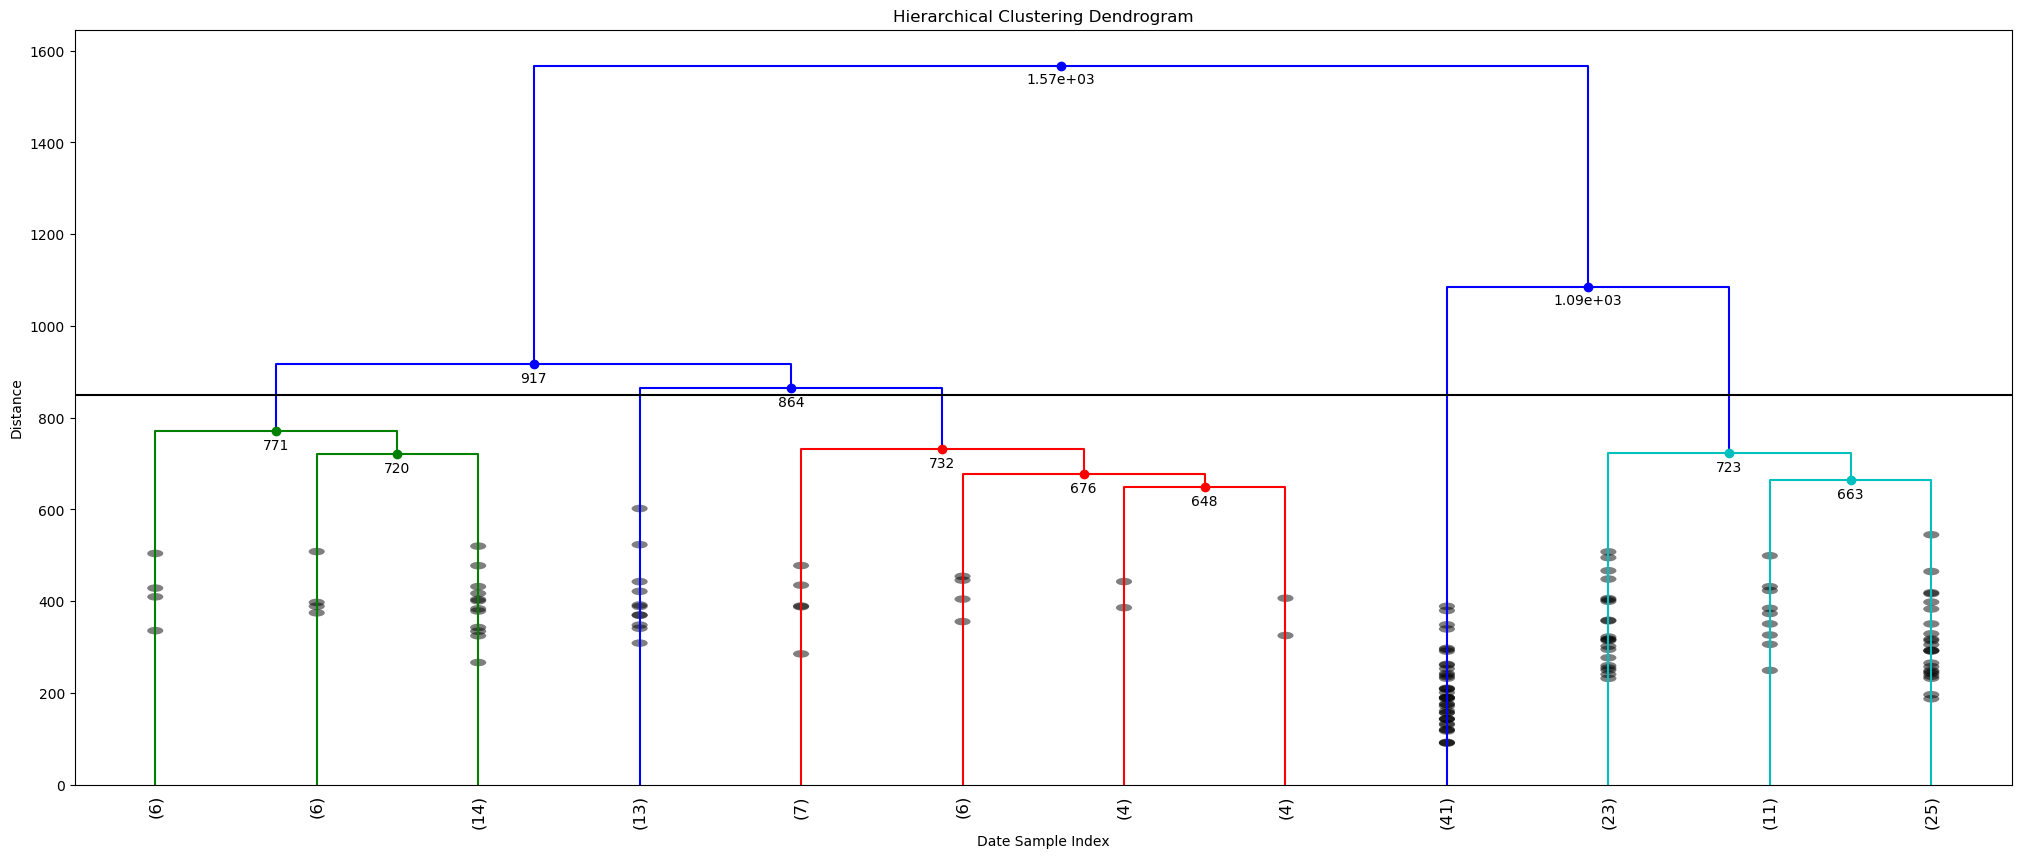

In [11]:
# set cut-off to 50
max_d = 850  # max_d as in max_distance

# generate the linkage matrix
Z = linkage(new_df.T.values, 'ward')

# calculate full dendrogram
plt.figure(figsize=(25, 10), dpi=100)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Date Sample Index')
plt.ylabel('Distance')
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
    max_d=max_d,  # plot a horizontal cut-off line

)
plt.show()
